# Using NLP to Categorize Movie Reviews into Positive or Negative Classifications

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [11]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [12]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-darkgrid')

In [14]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [15]:
# Load the data into df_reviews
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [16]:
# Take a look at the data
display(df_reviews.head())

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [17]:
# Check for duplicates
print(df_reviews.duplicated().sum())

0


In [18]:
# Call info to see what the columns contain
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [19]:
# Since there are only two rows with null values, I'm going to just drop them from the data
df_reviews.dropna(inplace=True)

### First look interpretations ###
Since the nature of this project is really only to work iwth the 'reviews' column and the 'pos' columns there isn't much need to work on the rest of the data. If this were a different type of task like predicting the 'rating' value, the other columns might also play factor. But since this is a classification task with the reviews as either positive or negative, I will not be doing any more cleaning work on the other columns.

## EDA

Let's check the number of movies and reviews over years.

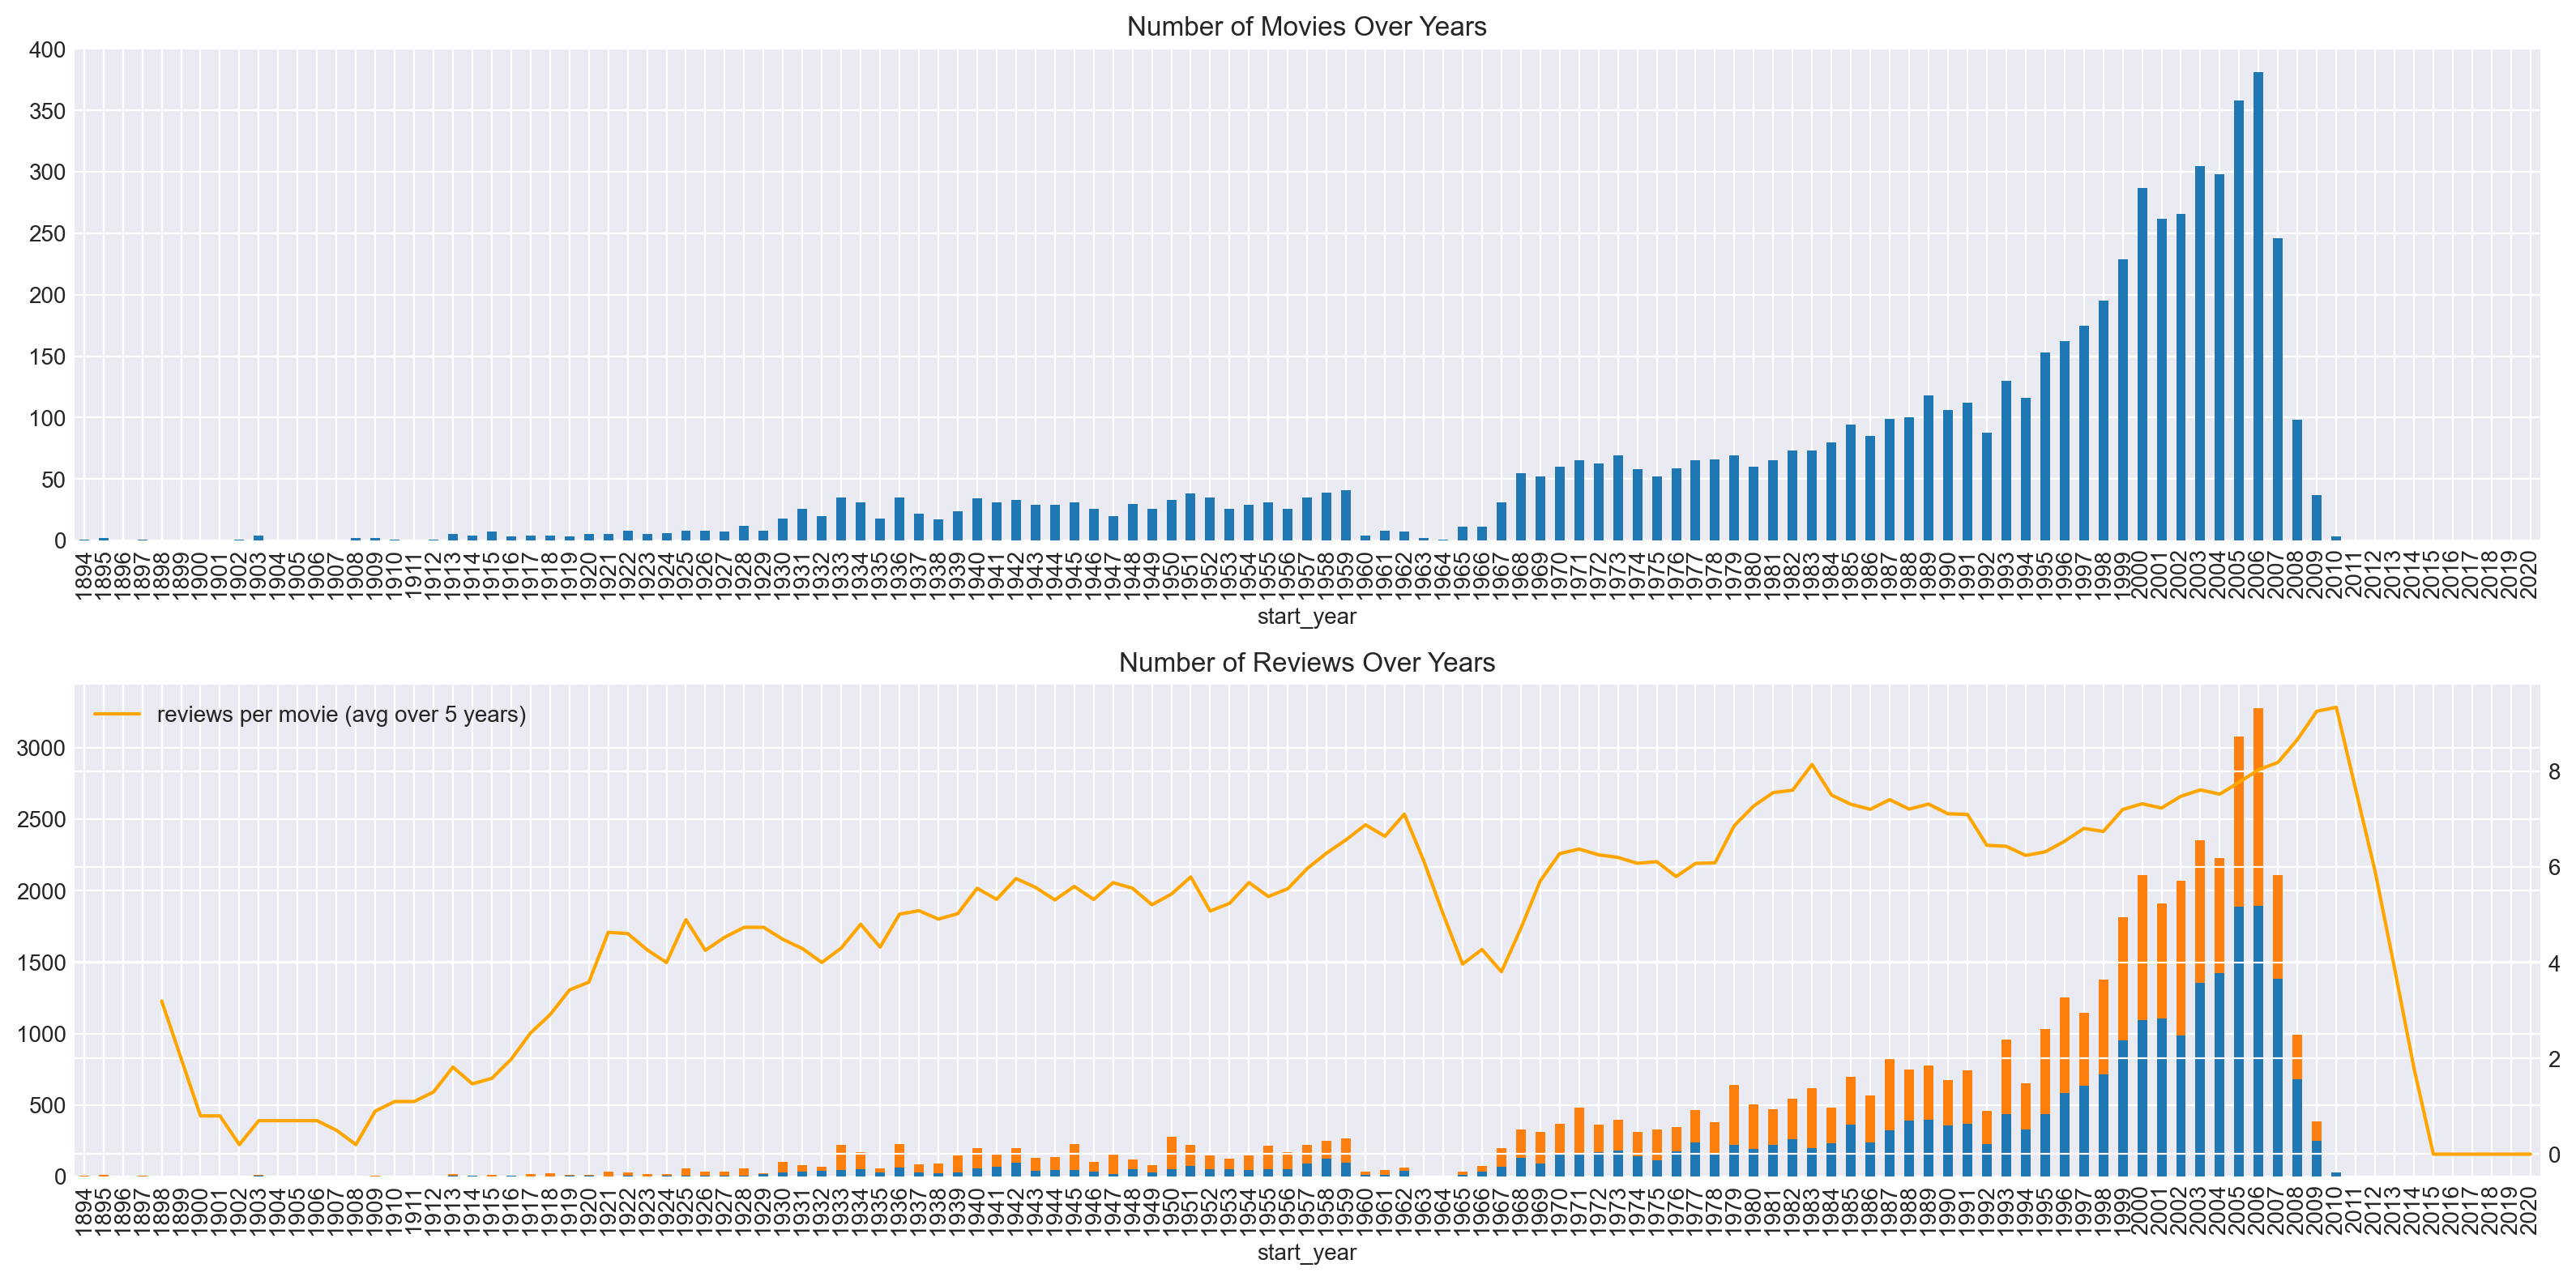

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

As we can see from the above charts, there have been far more movies made in recent years, and that comes with an increased volume of movie reviews. However, by overlaying the rolling average line of reviews per movie, we can actually see that the practice of viewers reviewing movies has stayed fairly even throughout the decades.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

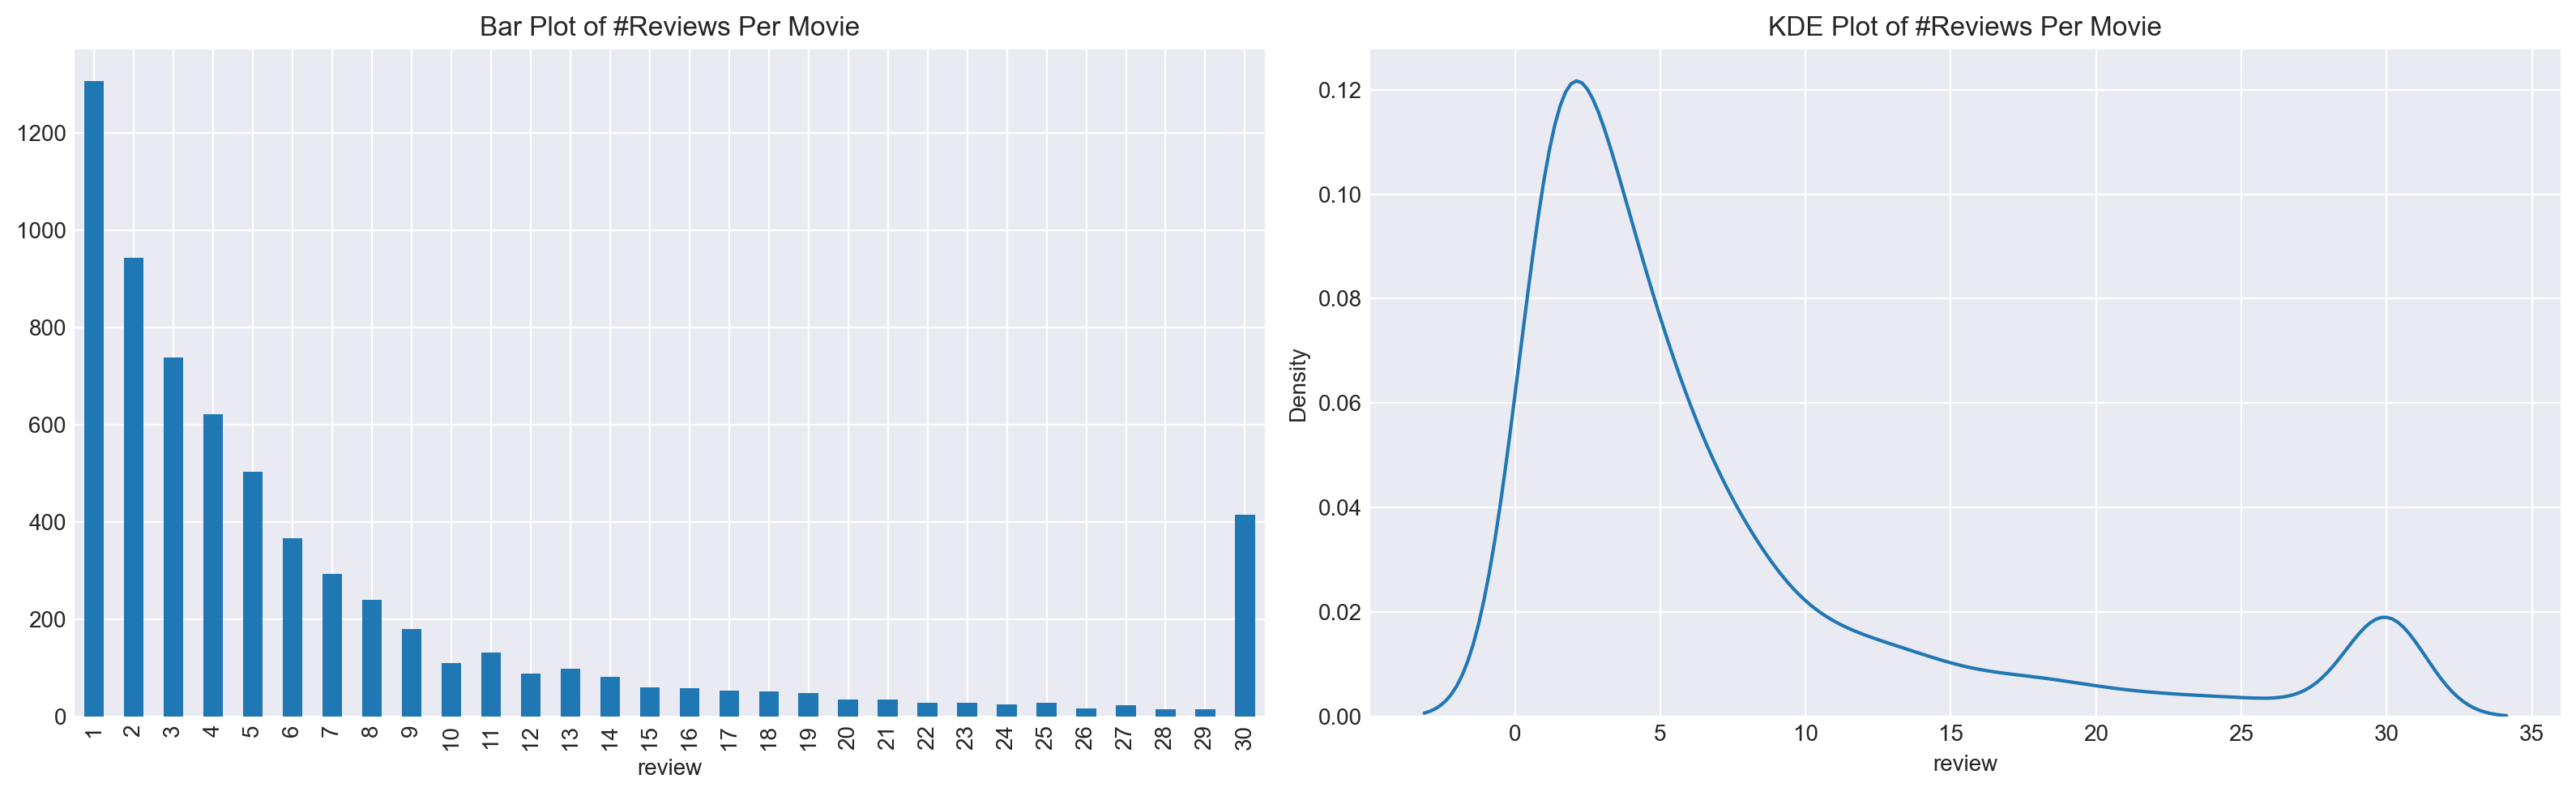

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We can see that people do not leave lots of reviews on movies. Infact, most movies only have 1-5 reviews. There is an interesting spike on some movies have 30+ reviews as well. These might be very popular movies, or those that have polarized audiences. I'd be curious to explore in another project with a different purpose which movies are included in those 30+ review group. 

In [22]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

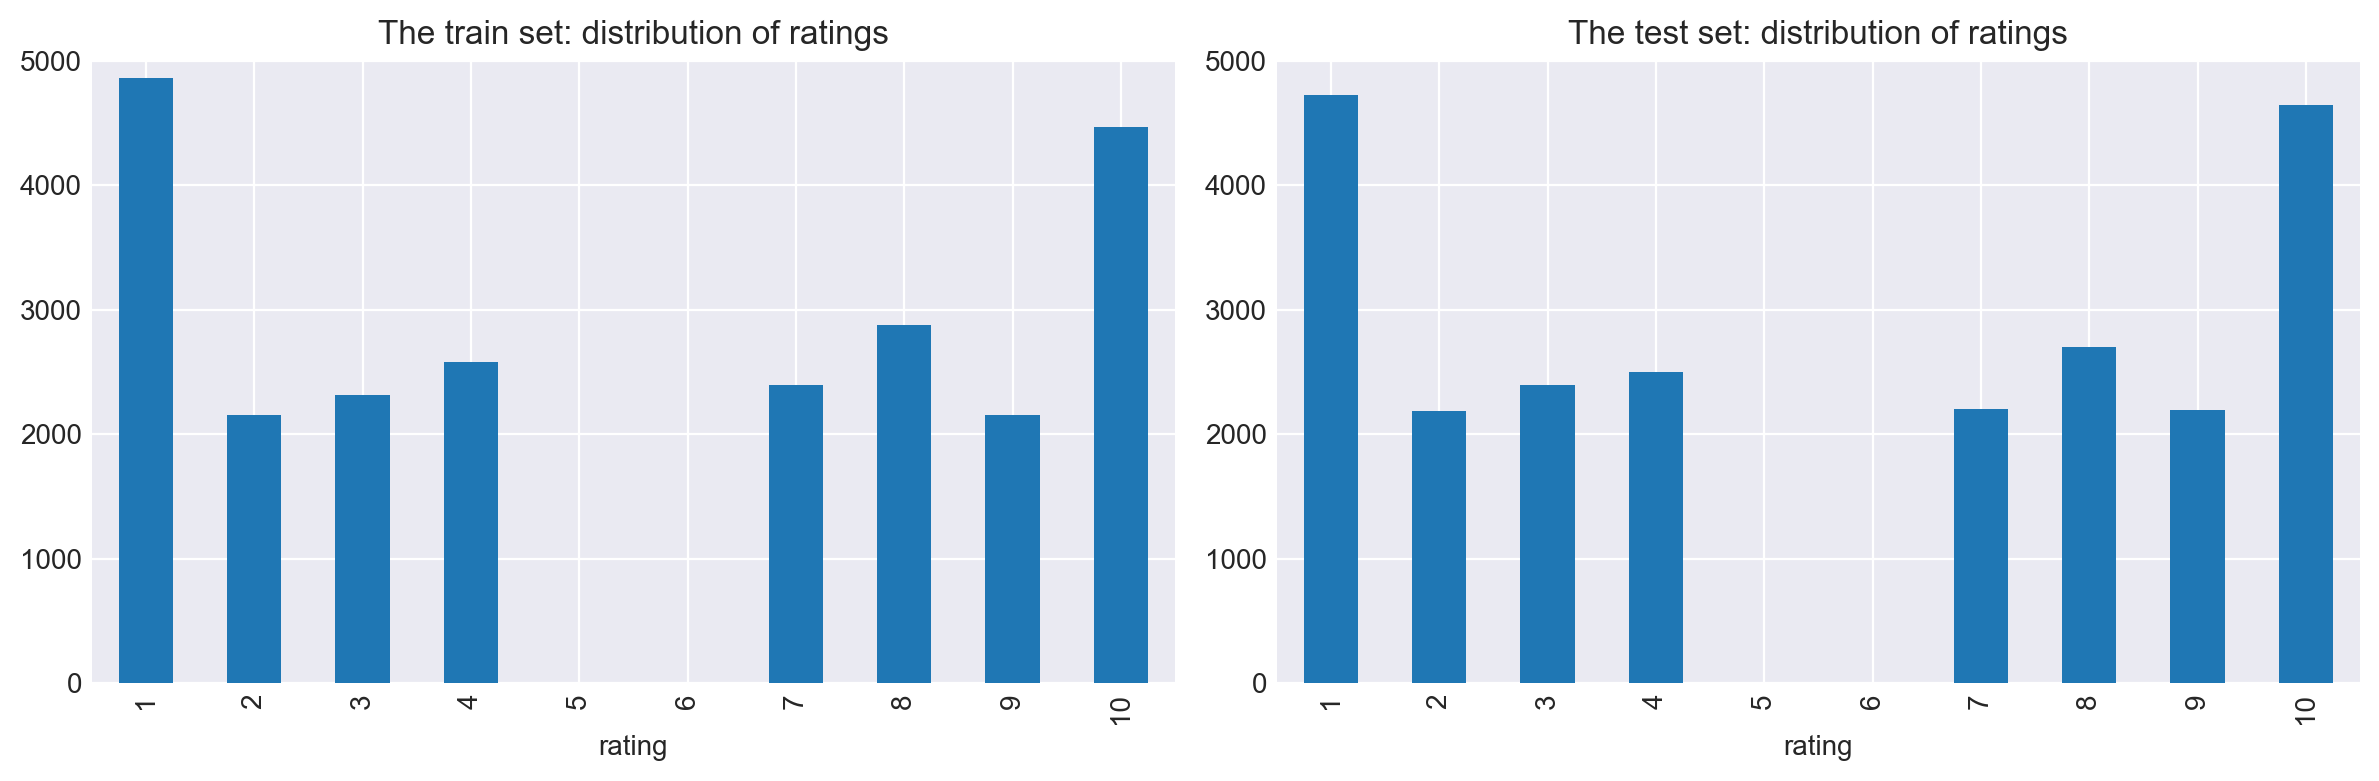

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

### Class balance ###
As seen above, we can see that the classes are close to balanced in both the training and test sets. So we do not need to do any up or down sampling to this data.

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\markl\AppData\Local\Temp\ipykernel_16476\2564148758.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\markl\AppData\Local\Temp\ipykernel_16476\2564148758.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\markl\AppData\Local\Temp\ipykernel_16476\2564148758.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\markl\AppData\Local\Temp\ipykernel_16476\2564148758.py:31: UserWarning: 

Support for a

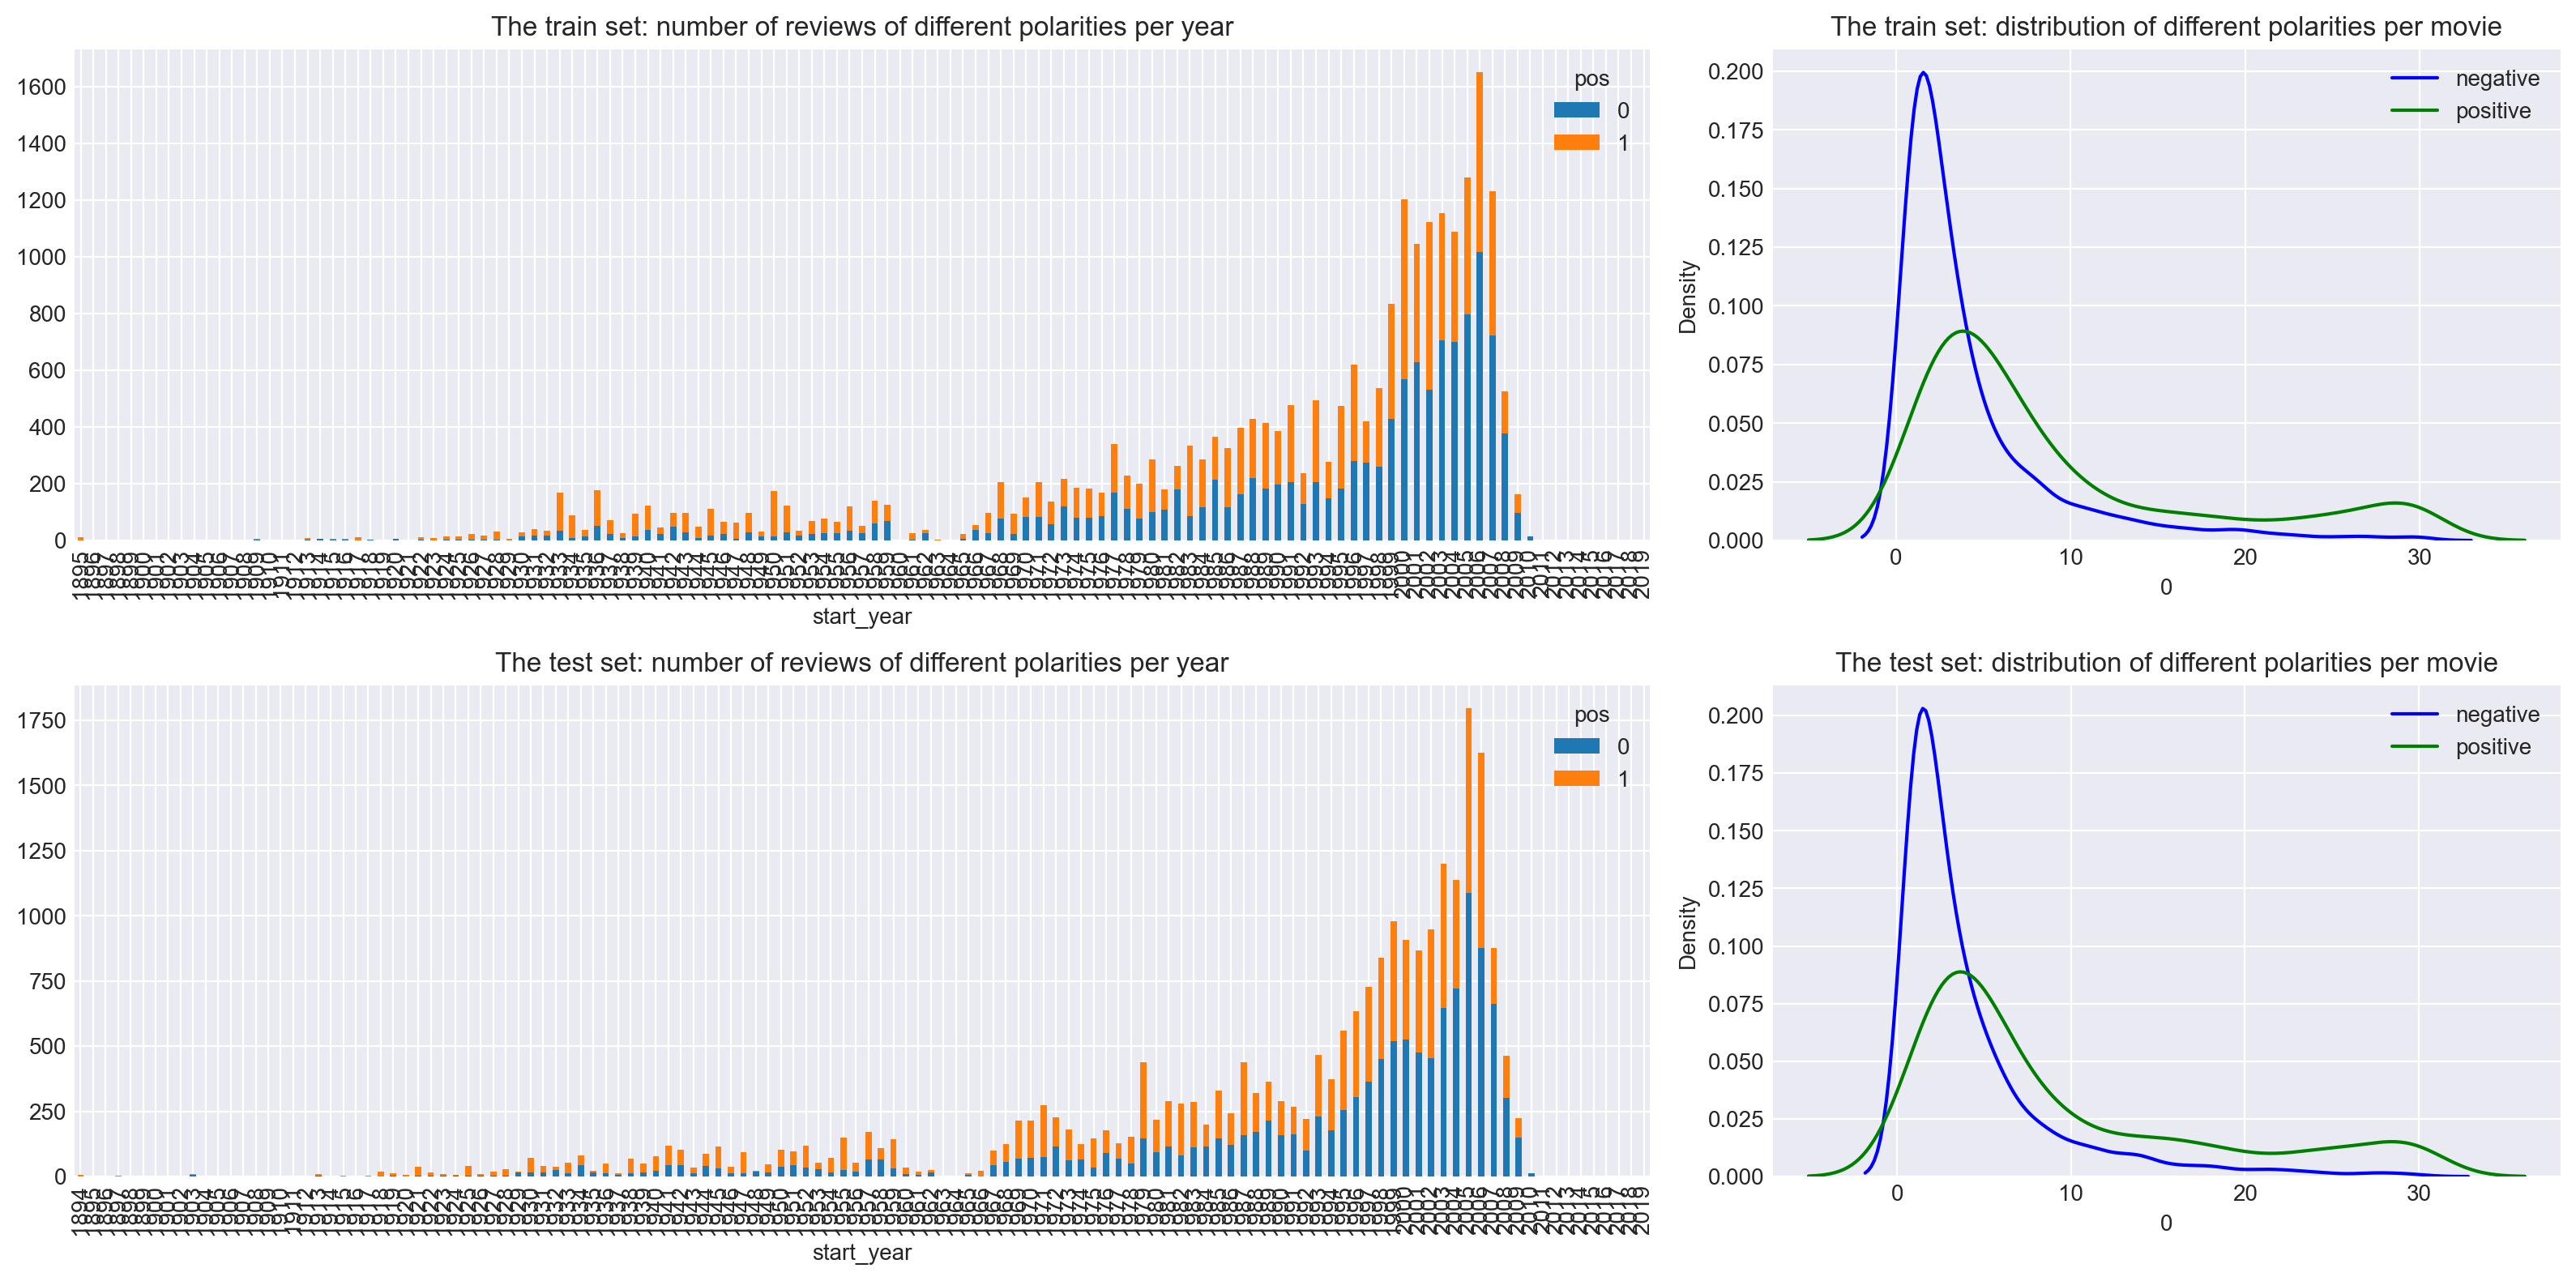

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Distribution of Positive and Negative Reviews over Time ###
As seen above, more recent movies have more reviews written about them. The distributions of both the train and test sets looks nearly the same, so we can expect that these two sets have been effectively split.

In the charts on the right side, we can see that the most movies have a small number of reviews as shown by the peak closer to the left side of the chart. There also appear to be more negative reviews than positi

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [25]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [26]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [27]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [28]:
display(df_reviews_train.head())

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlsons raiders is more of...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled balderdash little in t...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie gung ho the story of carlsons makin ...


## Working with models

### Model 0 - Constant

In [29]:
from sklearn.dummy import DummyClassifier

In [30]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

In [31]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(train_features, train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


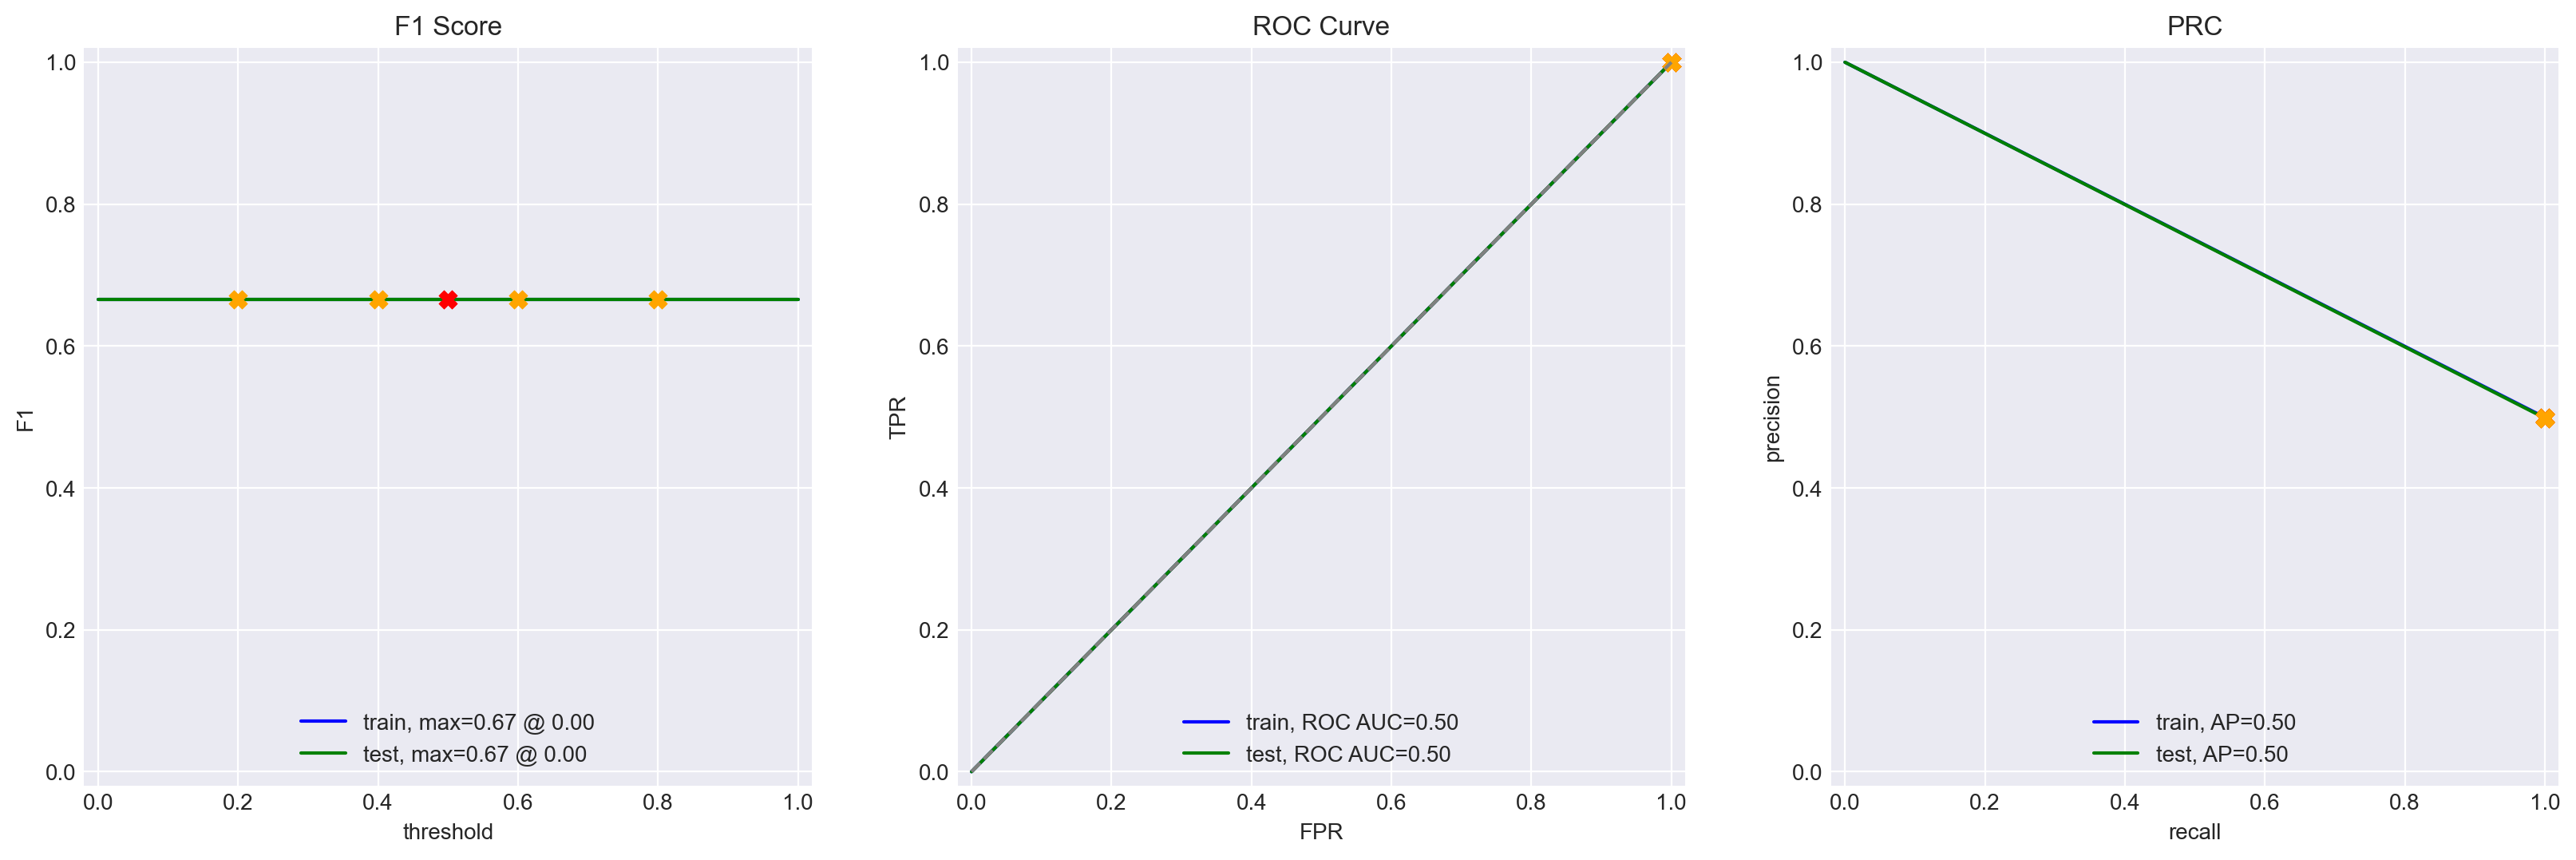

In [32]:
evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)


### Dummy Model evaluation ###
This model produced an F1 Score of .67 which will be our sanity measure for other models moving forward. If a model is too close to this number, then that model is ineffective at producing the needed precision for our task.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [33]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [34]:
#download stopwords
nltk.download('stopwords')

#initialize TF-IDF Vectorizer
vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\markl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [35]:
# Make features for the training and test sets
train_features_1 = vectorizer_1.fit_transform(train_features)
test_features_1 = vectorizer_1.transform(test_features)

In [36]:
# Initialize logistic regression model
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


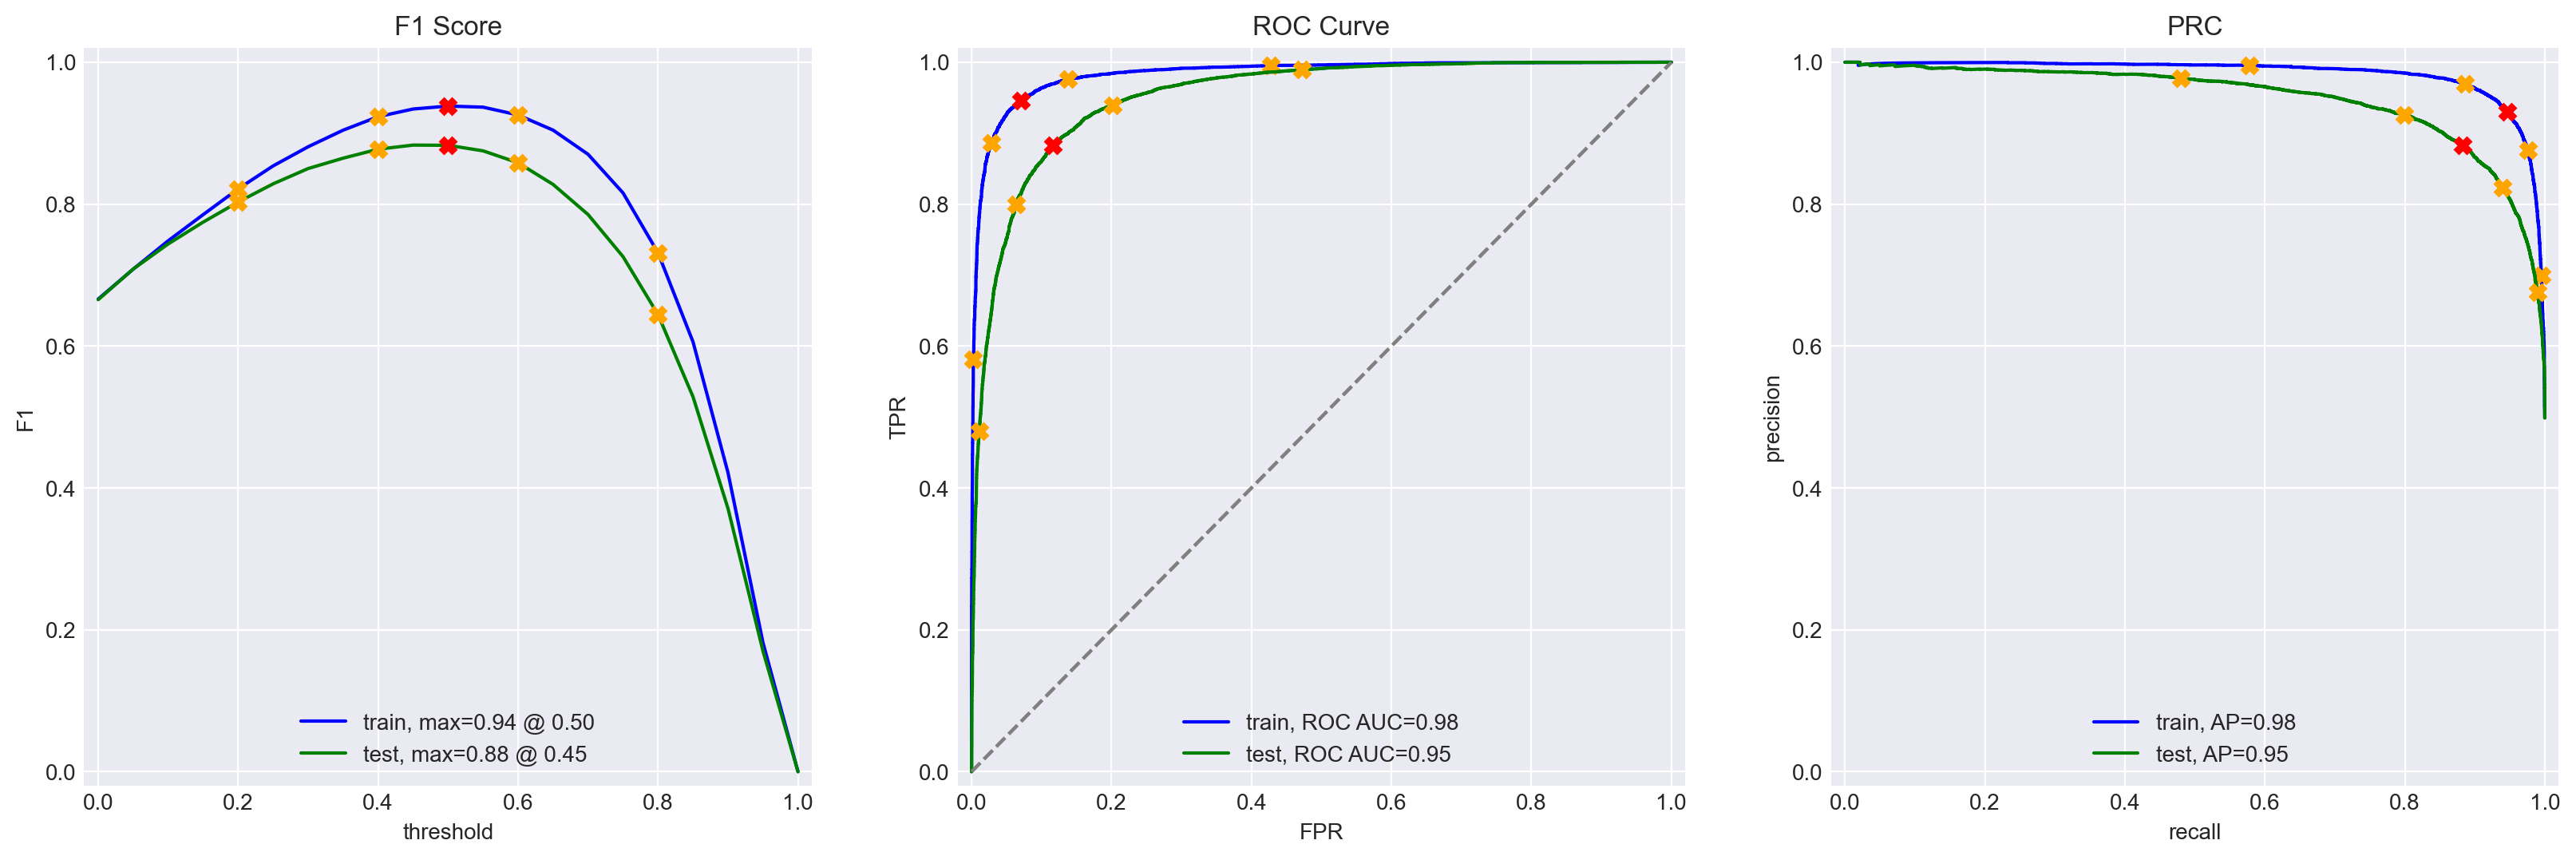

In [37]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 1 evaluation ###
As seen here, the test set was able to produce an F1 Score of .88 which is above our .85 threshold. That makes this a viable model for consideration for Film Junkie.

### Model 2 - spaCy, TF-IDF and LR

In [38]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

ModuleNotFoundError: No module named 'spacy'

In [ ]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [ ]:
train_features_processed = train_features.apply(text_preprocessing_3)
test_features_processed = test_features.apply(text_preprocessing_3)

In [ ]:
# Initialze vectorizer
vectorizer_3 = TfidfVectorizer()
train_features_3 = vectorizer_3.fit_transform(train_features_processed)
test_features_3 = vectorizer_3.transform(test_features_processed)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


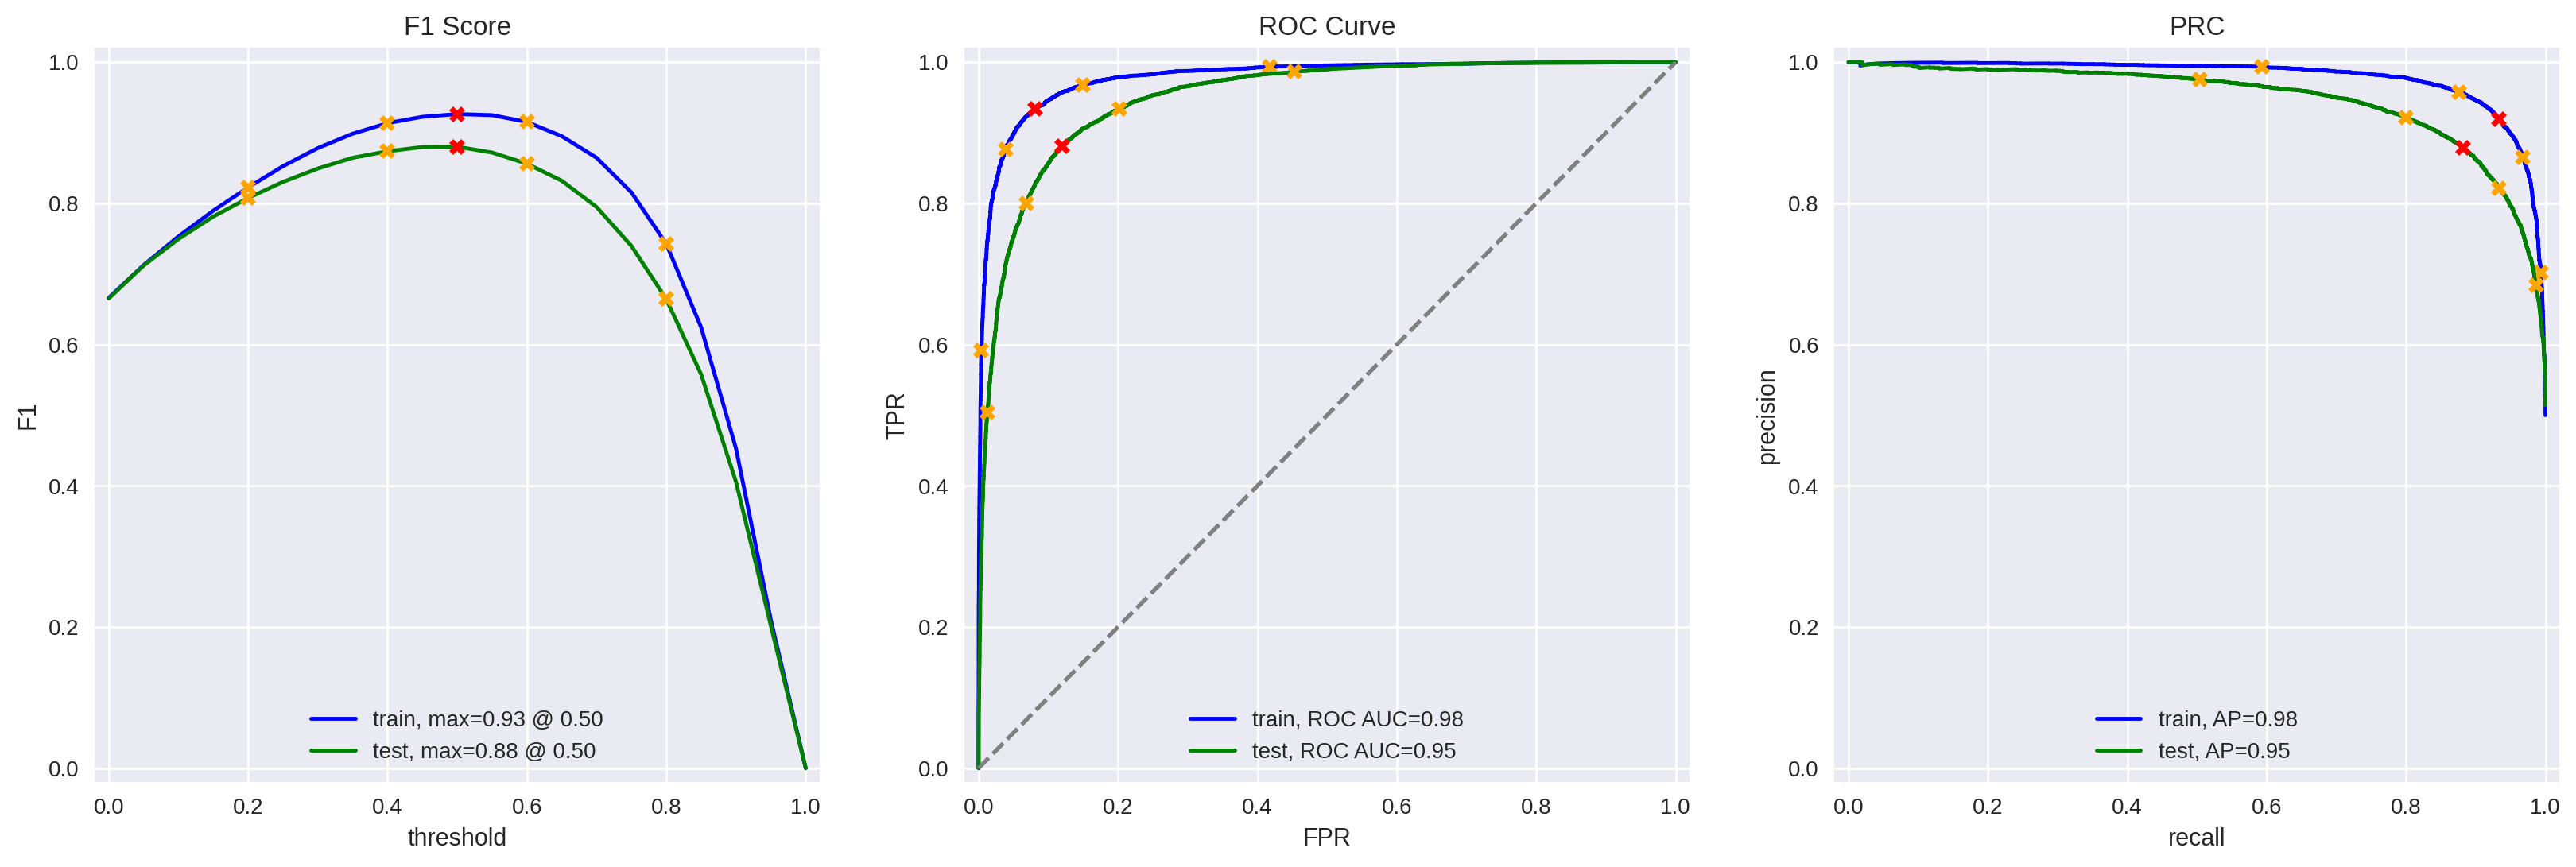

In [ ]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 2 Evaluation ###
Just like the previous model, Model 2 is was able to exceed our .85 target with an F1 Score of .88. This model is also worth consideration in our final review test.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Initialze vectorizer
vectorizer_4 = TfidfVectorizer()
train_features_4 = vectorizer_4.fit_transform(train_features_processed)
test_features_4 = vectorizer_4.transform(test_features_processed)

In [ ]:
train_features_4 = vectorizer_4.fit_transform(train_features_processed)
test_features_4 = vectorizer_4.transform(test_features_processed)

In [ ]:
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

LGBMClassifier()

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


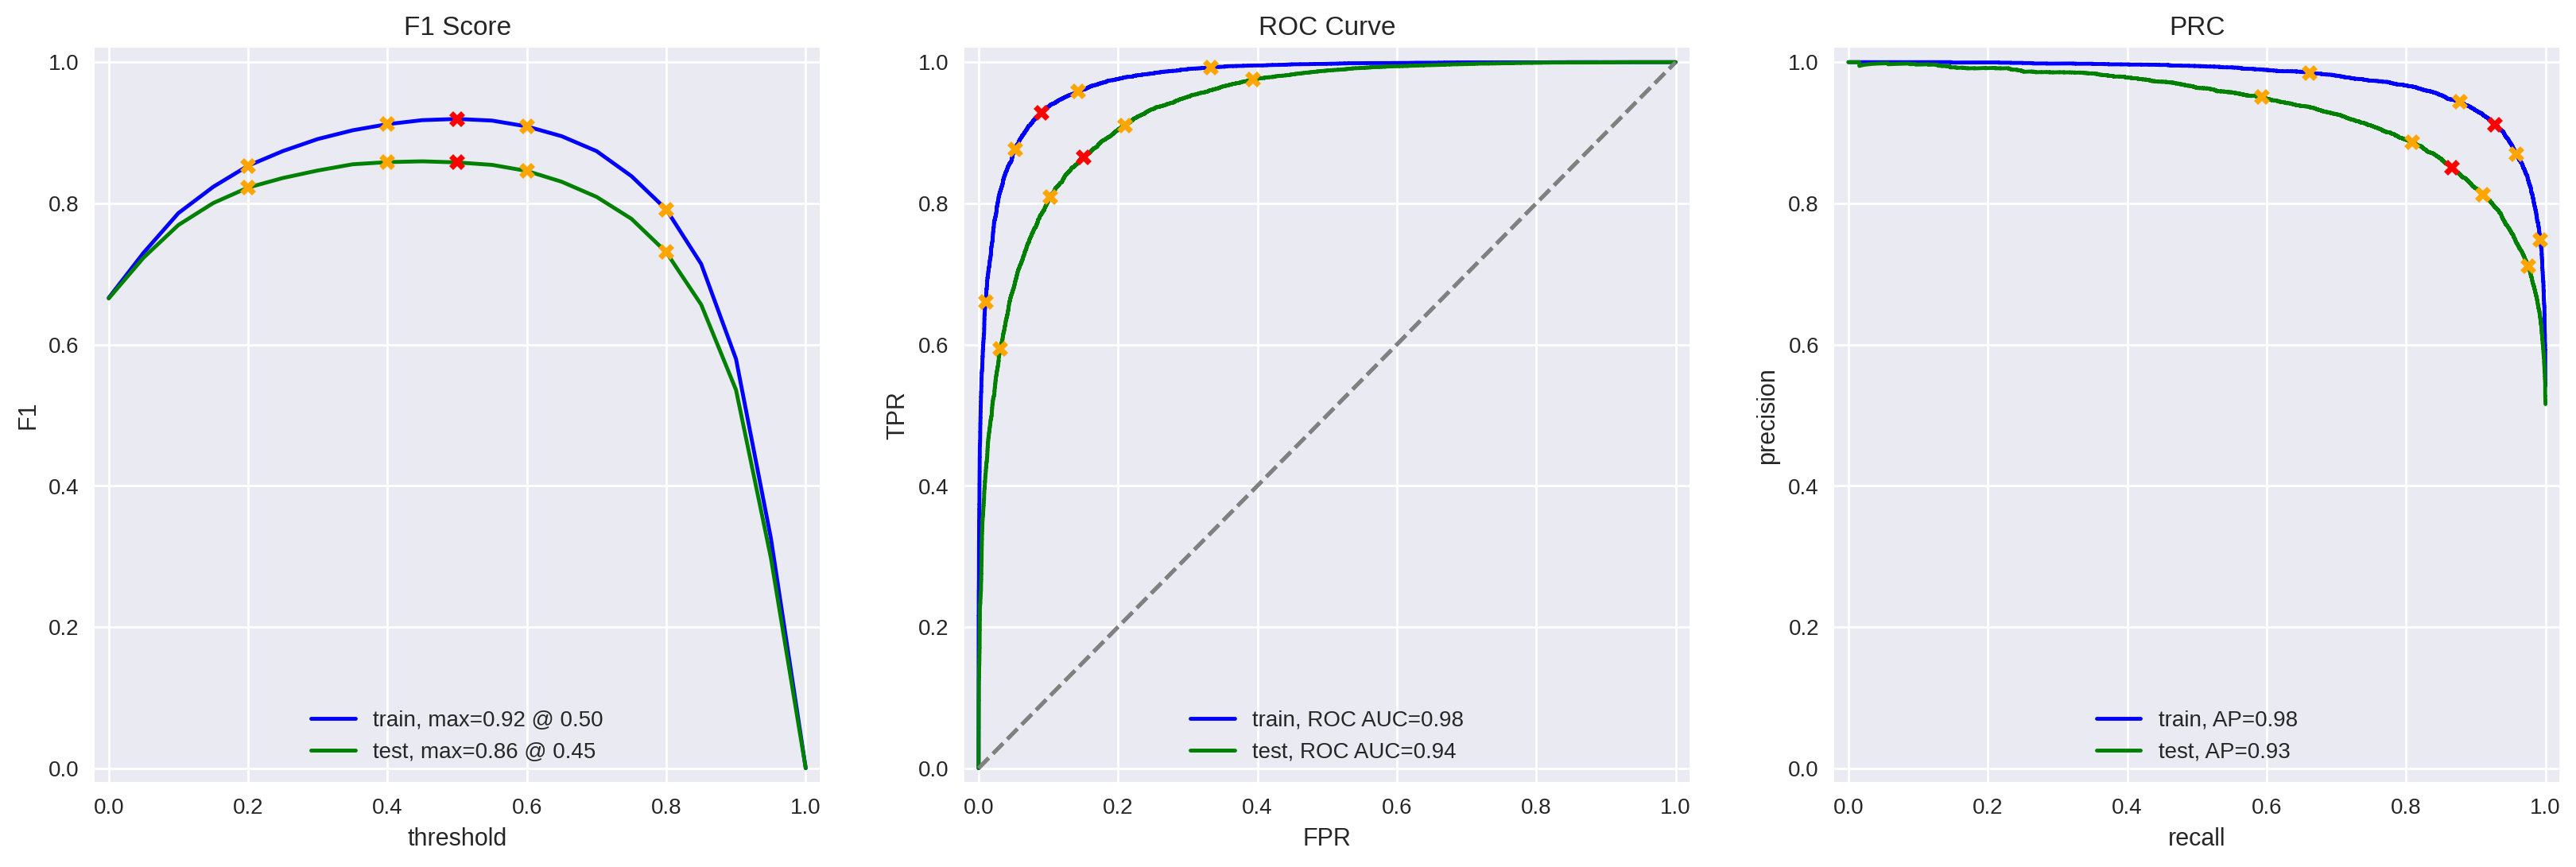

In [ ]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

### Model 3 Evaluation ###
As we can see here, the F1 score of .86 is enough to pass the .85 threshold. Since this model has not undergone any hyperparameter tuning, and is already is sufficient to meet our goal, it is very compelling for our final model. It will be interesting to see how it performs against sample reviews below.

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1: NLTK & LR

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 2: spaCy & LR

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.69:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3: spaCy & LGBM

In [ ]:
texts = my_reviews['review_norm']

vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.44:  i did not simply like it not my kind of movie
0.53:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.65:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didnt expect the reboot to be so good writers really cared about the source material
0.82:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

### Process Overview ###

In this project, Film Junkie Union tasked me with creating a model that predicts and classifies whether a review is positive or negative using language processing models. I used TF-IDF Vectorization and spaCy preprocessing in order to prepare the reviews for predictive classification modeling.

### Effects of TF-IDF and spaCy ###
Both TF-IDF Vectorization and spaCy preprocessing were effective at distinguishing between positive and negative reviews. And both were able to produce results above the 85% threshold that Film Junkie Union was looking to meet. 

### Model 1 ###
Model 1 utilized TF-IDF Vectorization with a Logistic Regression model. This model acheived the 85%  F1 Score, and when tested against the example reviews at the end of the project it was able to successfully classify most of the reviews. It did have a harder time than the other models of offering confidence in the more subtle/middle of the road reviews.
### Model 2 ###

Model 2 utilized the spaCy preprocessing with Logistic regression. Just like the other two models it was also able to meet the 85% F1 Score threshold in the test set. It proved effective as well with the example reviews and was able to distinguish between positive and negative reviews in most cases. It appears that just like model 1 it struggled to provide certain probability scores with subtle reviews. 
### Model 3 ###

Model 3 utilized spaCy preprocessing with the LGMB Classification model. This model also produced an F1 Score above the 85% threshold with the test set. It was the most different when handling the example reviews as it tended toward a more positive interpretation of the texts. Because the scores tended to be more balanced, this model would likely be the best for Film Junkie to use. 

### Recomendations ###
Since all three models failed to notice the positve tone of the 5th example review, I would recommend further hyperparameter tuning. 

Model 3, appears to be the most reliable for these reviews and with further tuning could become an even higher quality predictive model for Film Junkie Union to use.